In [1]:
#使用正弦函数和一些可加性噪声来生成序列数据，时间步为1,2，....1000
#给定过去的数据，预测未来
#用了隐马尔可夫假设

import torch
from torch import nn 
from d2l import torch as d2l




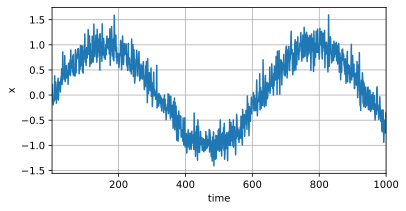

In [2]:
T = 1000   #1000个时间
time = torch.arange(1,T + 1,dtype=torch.float32)   #生成1-1000
x = torch.sin(0.01 * time) + torch.normal(0,0.2,(T,))  #sin（时间  * 0.01 ）  加   噪音
d2l.plot(time,[x],'time','x',xlim=[1,1000],figsize=(6,3))

In [4]:
#将数据映射为数据对  
tau = 4
features = torch.zeros((T-tau,tau))#  特征-996行，4列
for i in range(tau):
    features[:,i] = x[i:T - tau + i]  #每一列等于x的T-tau + i，，，x是1000个生成的数据，截取从第i个到....
labels = x[tau:].reshape((-1,1))#变为二维，，，一列，行自己计算
#特征是长为tau的序列，labels是tau序列后面那一个元素


batch_size,n_train = 16,600
train_iter = d2l.load_array((features[:n_train],labels[:n_train]),batch_size,is_train=True)

In [12]:
#使用一个拥有两个全连接层的多层感知机

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4,10),nn.ReLU(),nn.Linear(10,1))
    net.apply(init_weights)
    return net 
loss = nn.MSELoss()


In [13]:
def train(net,train_iter,loss,epochs,lr):
    trainer = torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}'
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
net = get_net()
train(net, train_iter, loss, 5, 0.01)
        

epoch 1loss: 0.051202
epoch 2loss: 0.049269
epoch 3loss: 0.046635
epoch 4loss: 0.048656
epoch 5loss: 0.048107


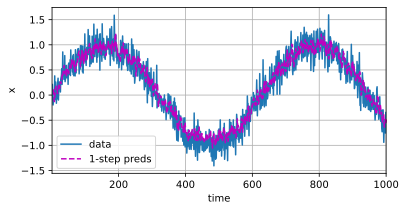

In [14]:
#预测下一个时间步  这是样本内的预测

onestep_preds = net(features)
d2l.plot(
         [time,time[tau:]],
         [x.detach().numpy(),onestep_preds.detach().numpy()],'time','x',
         legend = ['data','1-step preds'],xlim=[1,1000],figsize=(6,3)
)

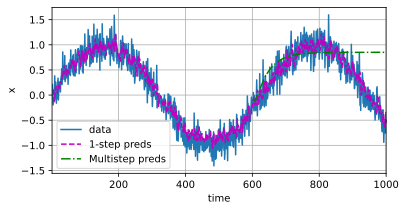

In [17]:
#进行多步预测

multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]   #前604个数据等于x的前604数据
for i in range(n_train + tau,T):    #后面的604-----T
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1,-1)))  #预测，，这里用的是i前面4个值

d2l.plot([time,time[tau:],time[n_train + tau:]],[x.detach().numpy(),
onestep_preds.detach().numpy(),
multistep_preds[n_train + tau:].detach().numpy()],
'time','x',legend=['data','1-step preds','Multistep preds'],xlim=[1,1000],figsize=(6,3))

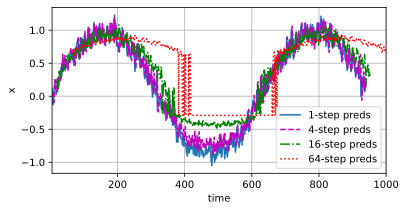

In [18]:
#K步预测


max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)  #分别预测未来的1,4,16,64个点
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))